In [1]:
import torch 
import torch.nn as nn
import os

import numpy as np
import random as rd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
import pickle as pkl

import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import torch 
import torch.nn as nn

import numpy as np
import random as rd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd

from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# from datasets import *

from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# from utils.datasets import FourragesDataset

os.chdir("C:/users/rapha/OneDrive/Bureau/IODAA/Cours AgroParisTech/Projet fil rouge")

with open("predictions/basic/eval_fnv_with_BERT_FT_2_epoch_5.pth", "rb") as file:
    fichier = torch.load(file, map_location=torch.device('cpu'))

# with open("predictions/basic/eval_fnv_with_BERT_FT_2_epoch_5.pkl", "rb") as file:
#     fichier = torch.load(file, map_location=torch.device('cpu'))

# with open("../bert-base-uncased_datasets.pkl", "rb") as file:
#     bert_base_uncased_datasets = pkl.load(file)
    
# with open("camembertav2-base_datasets.pkl", "rb") as file:
#     camembertav2_base_datasets = pkl.load(file)

# with open("num_only_datasets.pkl", "rb") as file:
#     num_only_datasets = pkl.load(file)

# with open("predictions/basic/eval_fnv_with_BERT_FT_2_epoch_5.pkl", "rb") as file:
#     fichier = pkl.load(file)

# predictions = np.squeeze(torch.cat(fichier["yhat"], dim=0).cpu().numpy())
# y_true = torch.cat(fichier["ytrue"], dim=0).cpu().numpy()
# predictions = fichier["yhat"].tolist()
# y_true = fichier["ytrue"]
# print(predictions)
# print(y_true)

# assert predictions.shape == y_true.shape, "Les dimensions de predictions et de y_true ne sont pas identiques"

In [4]:
import datasets
from utils.datasets import FourragesDataset, proper_loading
import pickle as pkl
from pathlib import Path

import os
print("Répertoire courant :", os.getcwd())
os.chdir("C:\\Users\\rapha\\OneDrive\\Bureau\\IODAA\\Cours AgroParisTech\\Projet fil rouge")



datasets.FourragesDataset = FourragesDataset
datasets.proper_loading = proper_loading

num_only_path = Path('num_only_datasets.pkl').resolve()
camemberta_path = Path('camembertav2-base_datasets.pkl').resolve()
bert_path = Path('bert-base-uncased_datasets.pkl').resolve()

num_only_datasets = proper_loading(str(num_only_path))
camemberta_datasets = proper_loading(str(camemberta_path))
bert_datasets = proper_loading(str(bert_path))

num_only_target_normalizer = num_only_datasets["Normalizer"]["target"]
camemberta_target_normalizer = camemberta_datasets["Normalizer"]["target"]
bert_target_normalizer = bert_datasets["Normalizer"]["target"]

Répertoire courant : C:\Users\rapha\OneDrive\Bureau\IODAA\Cours AgroParisTech\Projet fil rouge\utils


c:\Users\rapha\miniconda3\envs\DL_IODAA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\rapha\miniconda3\envs\DL_IODAA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\rapha\miniconda3\envs\DL_IODAA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.0 when using ver

In [5]:
def load_results(path, model):
    
    total_path = os.path.join(path+model)
    print("path :", total_path)
    with open(total_path, "rb") as file:
        fichier = torch.load(file, map_location=torch.device('cpu'))
    predictions = np.squeeze(torch.cat(fichier["yhat"], dim=0).cpu().numpy())
    y_true = torch.cat(fichier["ytrue"], dim=0).cpu().numpy()
    return y_true, predictions

def normalizer_choice(model="eval_fnv_with_BERT_FT_2_epoch_5.pth", target_normalizer=True):
    
    if target_normalizer is not None:
        if "BERT" in model or "bert" in model:
            target_normalizer = bert_target_normalizer
        elif "Camembertav2" in model or "CamemBERTaV2" in model:
            target_normalizer = camemberta_target_normalizer
        elif "num_only" in model:
            target_normalizer = num_only_target_normalizer
        else:
            raise ValueError("Problème avec le choix du normalizer")
        
        return target_normalizer

    else:
        return None

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
# y_true, predictions = load_results(path="predictions/basic/", model="eval_fnv_with_BERT_FT_2_epoch_5.pth")
# print(predictions, y_true)

In [6]:
target_names = ["UFL", "UFV", "BPR", "PDI", "PDIA"]

In [30]:
def plot_residuals(path="predictions/basic/", model="eval_fnv_with_BERT_FT_2_epoch_5.pth", \
    matplotlib=True, Plotly=False, target_normalizer=True):

    y_true, predictions = load_results(path, model)
    
    target_normalizer = normalizer_choice(model, target_normalizer)
    if target_normalizer is not None:
        predictions = target_normalizer.inverse_transform(predictions)
        y_true = target_normalizer.inverse_transform(y_true)

    if matplotlib:
        fig, axes = plt.subplots(len(target_names), 1, figsize=(8, 5 * len(target_names)))

        if len(target_names) == 1:  
            axes = [axes] 
        
    if matplotlib:
        for i, target in enumerate(target_names):
            print(target)
            
            Y_HAT = predictions[:, i]
            Y_TRUE = y_true[:, i]
            
            residuals = Y_TRUE - Y_HAT
            
            ax = axes[i]
            if matplotlib:
                plt.subplot(len(target_names), 1, i+1)
                plt.scatter(Y_TRUE, residuals, color='blue', alpha=0.7, label="Résidus")
                plt.axhline(0, color='red', linestyle='-', linewidth=1)  # Ligne y=0
                plt.xlabel("Prédictions")
                plt.ylabel("Résidus")
                plt.grid(linewidth=0.3, alpha=0.3, color='#000000')
                plt.title(f'Résidus {target} \n'
                          f'Mode : {path} \n'
                          f'Modèle : {model}' )
                plt.legend()
                plt.tight_layout()
                
                ax.grid(True)
            
    if matplotlib:    
        plt.show()

    if Plotly:
        for i, target in enumerate(target_names):
            
            Y_HAT = predictions[:, i]
            Y_TRUE = y_true[:, i]
            
            residuals = Y_TRUE - Y_HAT
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=Y_TRUE, y=residuals, mode='markers', marker=dict(color='blue'), name="Résidus"))
            fig.add_trace(go.Scatter(x=[min(Y_TRUE), max(Y_TRUE)], y=[0, 0], mode='lines', line=dict(color='red', dash='solid'), name="y=0"))
            fig.update_layout(title=f"Residuals {target}", xaxis_title="Prédictions", yaxis_title="Résidus")

            fig.update_layout(
            width=900,  # Largeur en pixels
            height=600  # Hauteur en pixels
            )
            
            fig.show()
    
plot_residuals(path="predictions/best/", model="eval_fnv_with_camembertav2-base_7.pth", matplotlib=False, Plotly=False, target_normalizer=True)


path : predictions/best/eval_fnv_with_camembertav2-base_7.pth


In [19]:
def show_predictions(path="predictions/basic/", model="eval_fnv_with_BERT_FT_2_epoch_5.pth", \
    target_names=target_names, target_normalizer=None, matplot=True, plotly = False, save=False, save_path="./model_test.pdf"):
    
    y_true, predictions = load_results(path, model)
        
    if predictions is None or y_true is None:
        raise ValueError("Les arguments `predictions` et `true_targets` doivent être fournis.")
    
    if target_names is None:
        raise ValueError("L'argument `target_names` doit être fourni.")
    
    target_normalizer_funtion = normalizer_choice(model, target_normalizer)
    if target_normalizer_funtion is not None:
        predictions = target_normalizer_funtion.inverse_transform(predictions)
        y_true = target_normalizer_funtion.inverse_transform(y_true)

    if matplot:
        fig, axes = plt.subplots(len(target_names), 1, figsize=(6.5, 6 * len(target_names)))

        if len(target_names) == 1:  # Gestion du cas où `target_names` a un seul élément
            axes = [axes] 

        for i, target in enumerate(target_names):
            Y_HAT = predictions[:, i]
            Y_TRUE = y_true[:, i]
            
            r2 = r2_score(Y_TRUE, Y_HAT)
            rmse = root_mean_squared_error(Y_TRUE, Y_HAT)
            mae = mean_absolute_error(Y_TRUE, Y_HAT)
            mape = mean_absolute_percentage_error(Y_TRUE, Y_HAT)

            ax = axes[i] 
            sns.scatterplot(x=Y_HAT, y=Y_TRUE, palette='viridis', hue=np.abs(Y_HAT - Y_TRUE), ax=ax)
            sns.lineplot(x=Y_TRUE, y=Y_TRUE, color='red', linestyle='dashed', ax=ax)  # Ligne y = x

            ax.set_title(f'Prédictions du modèle vs vérité terrain pour {target}\n'
                         f'Modèle utilisé : {model}\n'
                         f'Mode : {path}\n'
                         f'RMSE: {rmse:.4f}, R2: {r2:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}')
            ax.set_xlabel(f'Predicted {target}')
            ax.set_ylabel(f'True {target}')

            ax.grid(True)
            
        plt.tight_layout()
        
        if save:
            plt.savefig(save_path, format='pdf', bbox_inches='tight')
        
        plt.show()
        
    if plotly:  
        for i, target in enumerate(target_names):
            Y_HAT = predictions[:, i]
            Y_TRUE = y_true[:, i]

            df_plot = pd.DataFrame({f'Predicted {target}': Y_HAT, f'True {target}': Y_TRUE})
            fig = px.scatter(df_plot, x=f'Predicted {target}', y=f'True {target}', 
                             color=np.abs(Y_HAT - Y_TRUE), 
                             title=f'Model Predictions vs Ground Truth for {target}',
                             color_continuous_scale='viridis', 
                             labels={'color': f'Residuals for {target}'})
            fig.add_shape(type="line", x0=min(Y_TRUE), y0=min(Y_TRUE), x1=max(Y_TRUE), y1=max(Y_TRUE),
                          line=dict(color="red", width=2, dash="dash"))
            
            fig.update_layout(
            width=800,  # Largeur en pixels
            height=600  # Hauteur en pixels
            )
            
            fig.show()


show_predictions(path="predictions/basic/", model="eval_fnv_with_num_only_10.pth", matplot=False, plotly=False, target_normalizer=True)

path : predictions/basic/eval_fnv_with_num_only_10.pth


eval_fnv_with_bert-base-uncased_10.pth
eval_fnv_with_BERT_FT_2_epoch_5.pth
eval_fnv_with_camembertav2-base_10.pth
eval_fnv_with_CamemBERTaV2_FT_10_epoch_10.pth
eval_fnv_with_num_only_10.pth
eval_fnv_with_bert-base-uncased_7.pth
eval_fnv_with_BERT_FT_2_epoch_5_best.pth
eval_fnv_with_camembertav2-base_7.pth
eval_fnv_with_CamemBERTaV2_FT_10_epoch_7.pth
                                           Modèle Cible        MAE   Mode
0          eval_fnv_with_bert-base-uncased_10.pth   UFL   0.043126  basic
1          eval_fnv_with_bert-base-uncased_10.pth   UFV   0.051993  basic
2          eval_fnv_with_bert-base-uncased_10.pth   BPR   5.577342  basic
3          eval_fnv_with_bert-base-uncased_10.pth   PDI   3.282922  basic
4          eval_fnv_with_bert-base-uncased_10.pth  PDIA   3.043962  basic
5             eval_fnv_with_BERT_FT_2_epoch_5.pth   UFL   0.036641  basic
6             eval_fnv_with_BERT_FT_2_epoch_5.pth   UFV   0.050049  basic
7             eval_fnv_with_BERT_FT_2_epoch_5.pth   BPR 

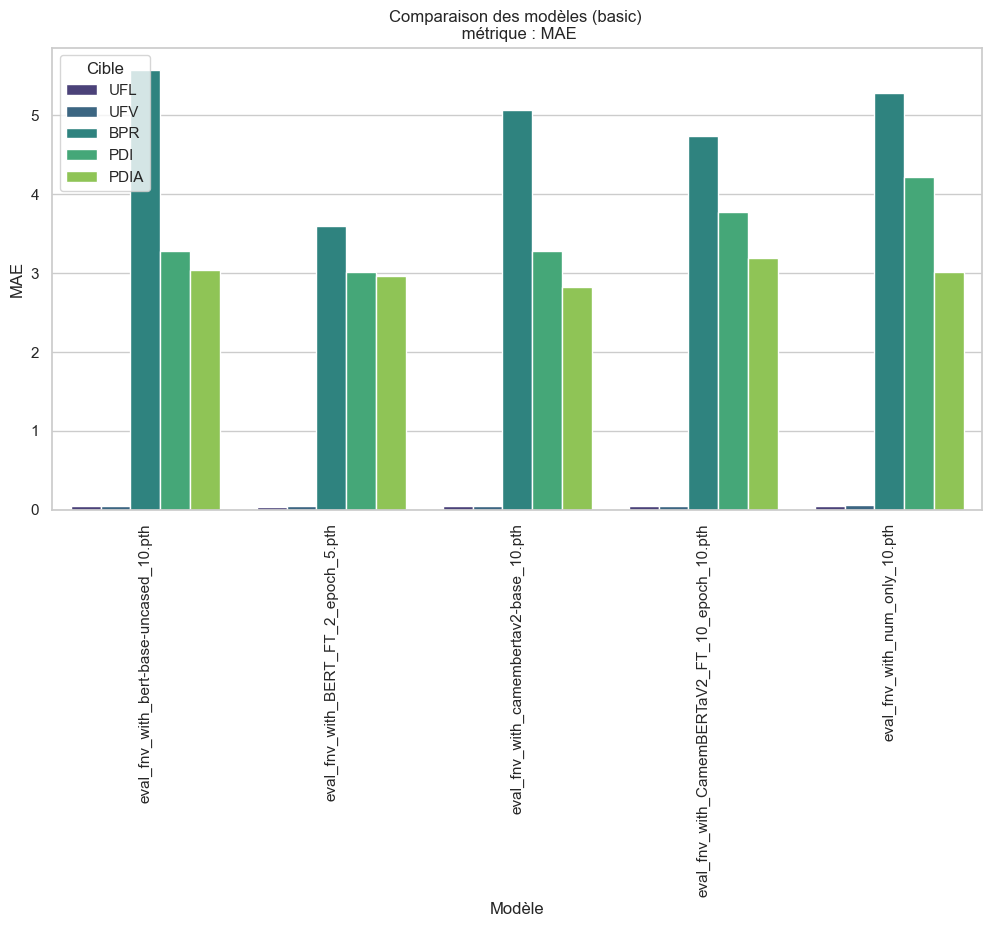

In [33]:
import os
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

def Plot_errors_models_4(mode=None, target_names=target_names, metric_fn=None, metric_name="Metric", selected_models=None, selected_mode=None, target_normalizer=True):
    if target_names is None:
        raise ValueError("target_names ne peut pas être None.")
    if metric_fn is None:
        raise ValueError("Veuillez fournir une fonction de métrique.")
    if metric_name is None:
        raise ValueError("Veuillez fournir un nom de métrique.")
    if selected_models is not None and selected_mode is not None:
        raise ValueError("Vous ne pouvez pas utiliser en même temps la séléction de modèle et la séléction de mode")
    
    paths = {
        "basic": os.path.join("predictions/", "basic/"),
        "best": os.path.join("predictions/", "best/")
    }

    dataset = []


    for mode_name, path in paths.items():
        if not os.path.exists(path):
            print(f"Avertissement : Le répertoire {path} n'existe pas. Il sera ignoré.")
            continue
        
        # print("mode :", mode)
        # print("path :", path)
        
        for filename in os.listdir(path):
            if filename.endswith(".pth"):
                file_path = os.path.join(path, filename)
                with open(file_path, "rb") as file:
                    data = torch.load(file, map_location=torch.device('cpu'))

                # Y_HAT = data["yhat"]
                # Y_TRUE = data["ytrue"]
                
                Y_HAT = torch.cat(data["yhat"], dim=0).cpu().numpy()
                Y_TRUE = torch.cat(data["ytrue"], dim=0).cpu().numpy()
                
                # print("Y_HAT",  Y_HAT.shape, "\n", "Y_TRUE", Y_TRUE.shape)

                print(filename)
                target_normalizer_funtion = normalizer_choice(model=filename, target_normalizer=target_normalizer)
                # print(target_normalizer_funtion)
                if target_normalizer_funtion is not None:
                    # print(Y_HAT, Y_TRUE)
                    Y_HAT = target_normalizer_funtion.inverse_transform(Y_HAT)
                    Y_TRUE = target_normalizer_funtion.inverse_transform(Y_TRUE)
                
                for i in range(len(target_names)):
                    predictions = Y_HAT[:, i]
                    y_true = Y_TRUE[:, i]
                    
                    # print("predictions :", y_true.shape)

                    metric_value = metric_fn(y_true, predictions)
                    dataset.append([filename, target_names[i], metric_value, mode_name])

    df = pd.DataFrame(dataset, columns=["Modèle", "Cible", metric_name, "Mode"])
    
    print(df)

    if selected_models is not None:
        df = df[df["Modèle"].isin(selected_models)]
    if selected_mode is not None:
        df = df[df["Mode"] == selected_mode]
        
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))

    sns.barplot(
        data=df,
        x="Modèle",
        y=metric_name,
        hue="Cible",
        palette="viridis",
        dodge=True
    )

    plt.title(f"Comparaison des modèles ({'basic & best' if selected_mode is None else selected_mode}) \n métrique : {metric_name}")
    plt.xlabel("Modèle")
    plt.ylabel(metric_name)
    plt.xticks(rotation=90)
    plt.legend(title="Cible")
    plt.show()

Plot_errors_models_4(metric_fn=mean_absolute_error, metric_name="MAE", selected_models=None, selected_mode='basic', target_normalizer=True)

eval_fnv_with_bert-base-uncased_10.pth
eval_fnv_with_BERT_FT_2_epoch_5.pth
eval_fnv_with_camembertav2-base_10.pth
eval_fnv_with_CamemBERTaV2_FT_10_epoch_10.pth
eval_fnv_with_num_only_10.pth
eval_fnv_with_bert-base-uncased_7.pth
eval_fnv_with_BERT_FT_2_epoch_5_best.pth
eval_fnv_with_camembertav2-base_7.pth
eval_fnv_with_CamemBERTaV2_FT_10_epoch_7.pth


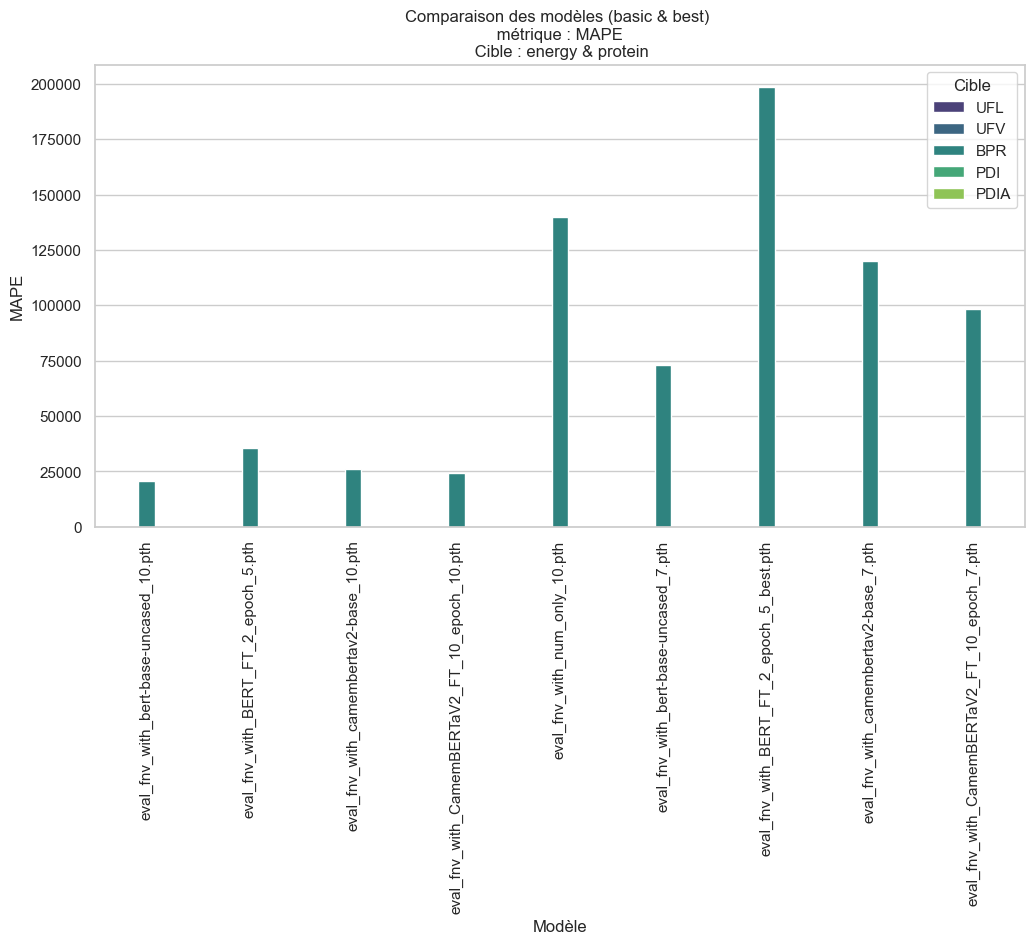

In [41]:
import os
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

def Plot_errors_models_5(mode=None, target_names=target_names, metric_fn=None, metric_name="Metric", selected_models=None, selected_mode=None, selected_target='energy', target_normalizer=True):
    if target_names is None:
        raise ValueError("target_names ne peut pas être None.")
    if metric_fn is None:
        raise ValueError("Veuillez fournir une fonction de métrique.")
    if metric_name is None:
        raise ValueError("Veuillez fournir un nom de métrique.")
    if selected_models is not None and selected_mode is not None:
        raise ValueError("Vous ne pouvez pas utiliser en même temps la séléction de modèle et la séléction de mode")
    
    paths = {
        "basic": os.path.join("predictions/", "basic/"),
        "best": os.path.join("predictions/", "best/")
    }

    dataset = []


    for mode_name, path in paths.items():
        if not os.path.exists(path):
            print(f"Avertissement : Le répertoire {path} n'existe pas. Il sera ignoré.")
            continue
        
        # print("mode :", mode)
        # print("path :", path)
        
        for filename in os.listdir(path):
            if filename.endswith(".pth"):
                file_path = os.path.join(path, filename)
                with open(file_path, "rb") as file:
                    data = torch.load(file, map_location=torch.device('cpu'))

                # Y_HAT = data["yhat"]
                # Y_TRUE = data["ytrue"]
                
                Y_HAT = torch.cat(data["yhat"], dim=0).cpu().numpy()
                Y_TRUE = torch.cat(data["ytrue"], dim=0).cpu().numpy()
                
                # print("Y_HAT",  Y_HAT.shape, "\n", "Y_TRUE", Y_TRUE.shape)

                print(filename)
                target_normalizer_funtion = normalizer_choice(model=filename, target_normalizer=target_normalizer)
                # print(target_normalizer_funtion)
                if target_normalizer_funtion is not None:
                    # print(Y_HAT, Y_TRUE)
                    Y_HAT = target_normalizer_funtion.inverse_transform(Y_HAT)
                    Y_TRUE = target_normalizer_funtion.inverse_transform(Y_TRUE)
                
                for i in range(len(target_names)):
                    predictions = Y_HAT[:, i]
                    y_true = Y_TRUE[:, i]
                    
                    # print("predictions :", y_true.shape)

                    metric_value = metric_fn(y_true, predictions)
                    dataset.append([filename, target_names[i], metric_value, mode_name])

    df = pd.DataFrame(dataset, columns=["Modèle", "Cible", metric_name, "Mode"])
    
    # print(df)

    if selected_models is not None:
        df = df[df["Modèle"].isin(selected_models)]
    if selected_mode is not None:
        df = df[df["Mode"] == selected_mode]
    if selected_target is not None:
        if selected_target == 'energy':
            df = df[df["Cible"].isin(["UFL", "UFV"])]
        elif selected_target == 'protein':
            df = df[df["Cible"].isin(["BPR", "PDI", "PDIA"])]
        else:
            raise ValueError("selected_target must be either 'energy' or 'protein'")
                
    # print(df)
        
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))

    sns.barplot(
        data=df,
        x="Modèle",
        y=metric_name,
        hue="Cible",
        palette="viridis",
        dodge=True
    )

    plt.title(f"Comparaison des modèles ({'basic & best' if selected_mode is None else selected_mode}) \n métrique : {metric_name} \n Cible : {selected_target if selected_target is not None else 'energy & protein'}")
    plt.xlabel("Modèle")
    plt.ylabel(metric_name)
    plt.xticks(rotation=90)
    plt.legend(title="Cible")
    plt.show()

Plot_errors_models_5(metric_fn=mean_absolute_percentage_error, metric_name="MAPE", selected_models=None, selected_mode=None, selected_target=None, target_normalizer=False)

# autre

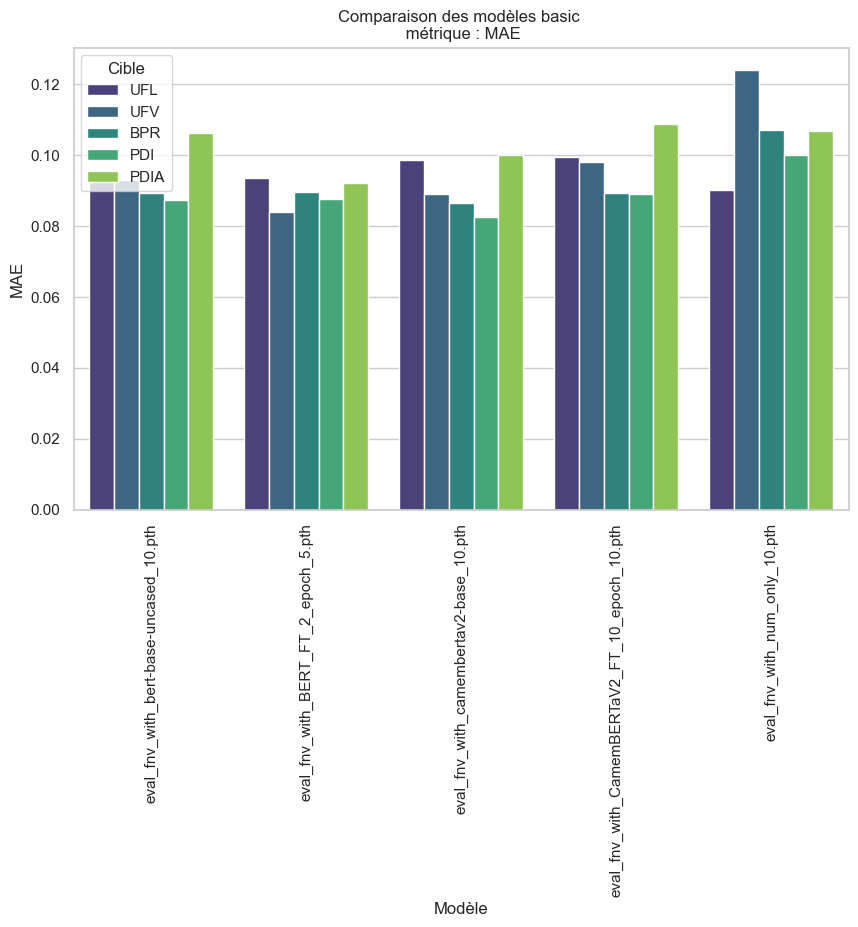

In [164]:
import os
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def Plot_errors_models_2(mode="basic", target_names=None, metric_fn=None, metric_name="Metric"):
    if target_names is None:
        raise ValueError("target_names ne peut pas être None.")

    if metric_fn is None:
        raise ValueError("Veuillez fournir une fonction de métrique.")

    if mode == "basic":
        total_path = os.path.join("predictions/", "basic/")
    elif mode == "best":
        total_path = os.path.join("predictions/", "best/")
    else:
        raise ValueError("Mode non valide. Choisissez 'basic' ou 'best'.")

    if not os.path.exists(total_path):
        raise FileNotFoundError(f"Le répertoire {total_path} n'existe pas.")

    dataset = []

    for filename in os.listdir(total_path):
        if filename.endswith(".pth"):
            file_path = os.path.join(total_path, filename)
            with open(file_path, "rb") as file:
                data = torch.load(file, map_location=torch.device('cpu'))

            Y_HAT = data["yhat"]
            Y_TRUE = data["ytrue"]

            for i in range(len(target_names)):
                predictions = Y_HAT[i].tolist()
                y_true = Y_TRUE[i].tolist()

                metric_value = metric_fn(y_true, predictions)
                dataset.append([filename, target_names[i], metric_value])

    df = pd.DataFrame(dataset, columns=["Modèle", "Cible", metric_name])
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    g = sns.barplot(
        data=df,
        x="Modèle",
        y=metric_name,
        hue="Cible",
        palette="viridis",
        dodge=True
    )

    plt.title(f"Comparaison des modèles {mode} \n métrique : {metric_name}")
    plt.xlabel("Modèle")
    plt.ylabel(metric_name)
    plt.xticks(rotation=90)
    plt.legend(title="Cible")
    plt.show()


Plot_errors_models_2(mode="basic", target_names=target_names, metric_fn=mean_absolute_error, metric_name="MAE")




In [ ]:
# import os
# import torch
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# def plot_errors_models_3(target_names=target_names, metric_fn=None, metric_name="Metric"):
#     """
#     Charge les prédictions des modèles de "basic" et "best", calcule une métrique et affiche un histogramme.

#     Arguments :
#     - target_names : list, noms des cibles utilisées pour la prédiction.
#     - metric_fn : fonction, métrique à utiliser (ex: mean_absolute_error, mean_squared_error).
#     - metric_name : str, nom de la métrique affichée dans le graphe.

#     Retourne :
#     - None (affiche directement un histogramme avec Seaborn)
#     """
#     if target_names is None:
#         raise ValueError("target_names ne peut pas être None.")
#     if metric_fn is None:
#         raise ValueError("Veuillez fournir une fonction de métrique.")

#     paths = {
#         "basic": os.path.join("predictions/", "basic/"),
#         "best": os.path.join("predictions/", "best/")
#     }
# #
#     dataset = []

#     for mode, path in paths.items():
#         if not os.path.exists(path):
#             print(f"Avertissement : Le répertoire {path} n'existe pas. Il sera ignoré.")
#             continue  

#         for filename in os.listdir(path):
#             if filename.endswith(".pth"):
#                 file_path = os.path.join(path, filename)
#                 with open(file_path, "rb") as file:
#                     data = torch.load(file, map_location=torch.device('cpu'))

#                 Y_HAT = data["yhat"]
#                 Y_TRUE = data["ytrue"]

#                 for i in range(len(target_names)):
#                     predictions = Y_HAT[i].tolist()
#                     y_true = Y_TRUE[i].tolist()

#                     metric_value = metric_fn(y_true, predictions)
#                     dataset.append([filename, target_names[i], metric_value, mode])

#     df = pd.DataFrame(dataset, columns=["Modèle", "Cible", metric_name, "Mode"])
#     print(df)

#     # Affichage du graphique Seaborn
#     sns.set(style="whitegrid")
#     plt.figure(figsize=(12, 6))

#     g = sns.barplot(
#         data=df,
#         x="Modèle",
#         y=metric_name,
#         hue="Cible",
#         palette="viridis",
#         dodge=True
#     )

#     plt.title(f"Comparaison des modèles ('basic' vs 'best') \n Métrique : {metric_name}")
#     plt.xlabel("Modèle")
#     plt.ylabel(metric_name)
#     plt.xticks(rotation=45, ha='right')
#     plt.legend(title="Cible")
#     plt.show()


# plot_errors_models_3(target_names, metric_fn=mean_absolute_error, metric_name="MAE")
